# Практическое задание
## Урок 6. Градиентный бустинг

### 1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coefs=None, eta=.1):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    if coefs == None:
        coefs = [1] * len(trees_list)
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coefs)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs=None, eta=.1):
    
    if coefs == None:
        coefs = [1] * n_trees
    
    # Деревья будем записывать в список
    trees = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

        trees.append(tree)
    
    train_error = mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))
    test_error = mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta))
        
    return trees, train_error, test_error

In [8]:
def errors_plot(x_label, x_list, errors_list, legend_loc):
    plt.figure(figsize=(5, 5))

    plt.xlabel(x_label)
    plt.ylabel('MSE')

    plt.plot(x_list, errors_list[0], label='train error')
    plt.plot(x_list, errors_list[1], label='test error')

    plt.legend(loc=legend_loc)
    plt.show()

#### Зависимость ошибки от числа деревьев

In [9]:
max_depth = 3
n_trees_list = np.arange(10, 101, 10)
n_trees_list

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [10]:
%%time
trees_errors_list = []
for n_trees in n_trees_list:
    _, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test)
    trees_errors_list.append([train_error, test_error])

Wall time: 7min 22s


In [11]:
trees_errors_list = np.array(trees_errors_list).T

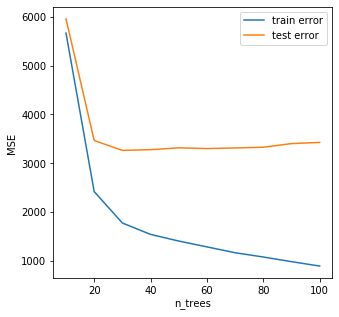

In [12]:
errors_plot(x_label='n_trees', x_list=n_trees_list, errors_list=trees_errors_list, legend_loc='upper right')

#### Вывод
Ошибка на обучающей выборке всегда падает с ростом числа деревьев, а на тестовой с какого-то момента начинает расти, то есть можем говорить о появлении переобучения и имеет смысл остановиться на минимуме ошибки тестововй выборки.

То есть ~30 деревьев оптимальный вариант в нашем примере.

#### Зависимость ошибки от максимальной глубины деревьев

In [23]:
n_trees = 30
max_depth_list = np.arange(1, 11)
max_depth_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [24]:
%%time
depth_errors_list = []
for max_depth in max_depth_list:
    _, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test)
    depth_errors_list.append([train_error, test_error])

Wall time: 1min 15s


In [25]:
depth_errors_list = np.array(depth_errors_list).T

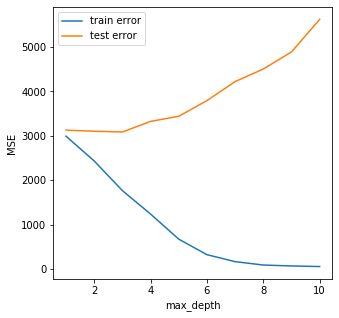

In [29]:
errors_plot(x_label='max_depth', x_list=max_depth_list, errors_list=depth_errors_list, legend_loc='upper left')

#### Вывод
Ошибка на обучающей выборке также всегда падает с ростом глубины деревьев, а на тестовой с какого-то момента начинает расти, то есть можем говорить о появлении переобучения и имеет смысл остановиться на минимуме ошибки тестововй выборки.

То есть ~3 оптимальный вариант в нашем примере.

### 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

Функция возвращает подвыборки двух массивов.

`p` - часть подвыборки. Например `.5`, то есть половина.

In [17]:
def subsampling(X, y, p):
    l = len(X)
    len_subsample = int(l * p // 1)
    indexes = np.random.choice(l, len_subsample, replace=False)
    
    X_sub = []
    y_sub = []
    
    for i, index in enumerate(indexes):
        X_sub.append(X[index])
        y_sub.append(y[index])
        
    return X_sub, y_sub

In [18]:
def gb_stoch_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs=None, eta=.1):
    
    if coefs == None:
        coefs = [1] * n_trees
    
    # Деревья будем записывать в список
    trees = []

    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        X_sub, y_sub = subsampling(X_train, y_train, p=.5)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_sub, y_sub)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_sub, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_sub, bias(y_sub, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [19]:
max_depth = 3
n_trees = 100

In [20]:
%%time
trees, train_errors, test_errors = gb_stoch_fit(n_trees, max_depth, X_train, X_test, y_train, y_test)

Wall time: 3min 32s


In [21]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

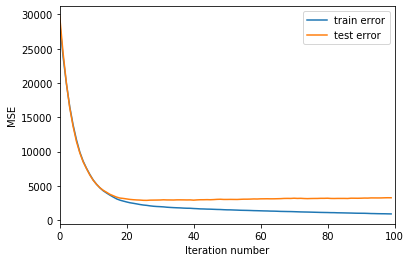

In [22]:
get_error_plot(n_trees, train_errors, test_errors)

#### Вывод
Мы сэкономили время и ошибка на тестовой выборке стала даже немного меньше, то есть в нашем примере стохастический градиентный бустинг работает лучше.